## CNN Transfer Learning Exercise
Jenica Andersen

Instructions
For this exercise, we'll practice building convolutional neural networks and applying transfer learning, working with our old friend the MNIST digit data.

1. Start by loading in the data for the digits [0, 1, 2] and preparing it for modeling, including a train-test split.
You can modify the code block given below, adding in the appropriate steps specified by the ### comments. In particular, you should filter down to only the first 3 digits, rescale pixel strengths to 0 to 1 scale, and repeat the pixel strengths across 2 additional channels. We perform the last step to ensure that we can apply transfer learning with base models that require 3 color channels of input.

Hint: For the 3rd modification, read the documentation for the np.repeat function.

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

mnist = fetch_openml('mnist_784')

X_digits, Y_digits = mnist.data, mnist.target.astype(np.int64)
### FILTER DOWN TO DIGITS [0,1,2]
### RESCALE THE PIXELS

# 28x28 images, with grey scale pixel strengths repeated across 3 channels for color representation
X_digits = X_digits.values.reshape((-1,28,28,1)) 
### REPEAT VALUES ACROSS 2 ADDITIONAL CHANNELS

X_train, X_test, y_train, y_test = (train_test_split(X_digits, Y_digits, 
                                                     test_size = .2, random_state = 42))

# 2D (one-hot encoded) representation of multiclass target 
y_train_cat = np_utils.to_categorical(y_train)

2. Use keras to build a simple CNN model from scratch for this 3-class problem. With a very simple model, it should be possible to exceed 99% accuracy on train, validation, and test.
You may use the CNN lesson material as a reference for this and the next step.

3. Use keras to build a transfer learning CNN for this problem: VGG16 is recommended as the base model. Make sure to freeze the layers in the pretrained base before training!
VGG16 requires a minimum input shape of 32x32 pixels, so you will need to add a ZeroPadding2D(padding=2) layer after your input layer to slightly upsize the raw data (28x28) by adding 0s at the corners.

Prioritize getting a functioning, trainable model for this step. If time permits, try to adjust your parameters to beat the validation and test scores you saw for your from scratch model.

<>:110: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:110: SyntaxWarning: "is" with a literal. Did you mean "=="?


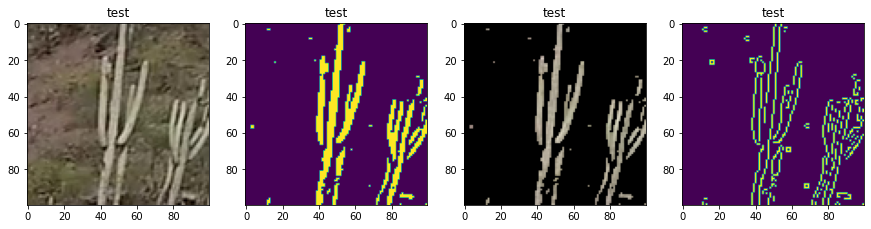

/var/folders/03/wt9n4zzx74519f561hzp03nw0000gn/T/ipykernel_83888/2700456601.py:110: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if directory is 'cactus_dir':
  0%|          | 0/13136 [00:00<?, ?it/s]

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [18]:
#https://www.kaggle.com/code/wilmerben/aerial-cactus-identification 
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_absolute_error
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

training_path = "/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/cactus_data/training_set/"
validation_path = "/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/cactus_data/validation_set/"
all_features = ['is_cactus','shape', 'color','texture']



def get_image(image_uri, showImage=False):
    ''' Read, convert, and flatten the image.
    '''
    STANDARD_SIZE = (100,100)
    image = mpimg.imread(image_uri)
    image = cv2.resize(image, STANDARD_SIZE, interpolation=cv2.INTER_CUBIC)  
    image_non_flat = image
    image = image.flatten()
    return image, image_non_flat


def get_shape_feature(image_array, showImage=False):
    '''Returns the image shape matricies with 0s and 1s'''
    image_gray = gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    (thresh, image_bw) = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    thresh = 127
    image_bw = cv2.threshold(image_gray, thresh, 255, cv2.THRESH_BINARY)[1]
    #edges should be used in the texture feature 
    #
    shape = image_bw
    shape_array = shape
    shape = shape.flatten()
    return (shape.flatten(), shape_array)


def get_color_feature(image_array, shape_array):
    '''Returns matricies of the forground color. '''
    #color = np.where((shape<1),0,image).astype('uint8')
    height, width = 100, 100
    nchannels = 3
    #shape_array = np.resize(shape_array, (height, width, nchannels))
    shape_array = cv2.cvtColor(shape_array,cv2.COLOR_GRAY2RGB)
    mask = np.zeros(shape_array.shape,np.uint8)
    color_array = np.where(shape_array == 0, 0, image_array)
    color = color_array.flatten()
    return (color, color_array)

def get_texture_feature(shape_array, image_array):
    ''' Returns the matricies of the texture. Needs some works. '''
    edges = cv2.Canny(shape_array, 100, 100)
    texture = edges.flatten()
    texture_array =  edges
    return (texture, texture_array)

def feature_debugger():

    image, image_array = get_image(os.path.join(training_path,'cactus','cactus_0028_1.jpg'))
    shape, shape_array = get_shape_feature(image_array)
    texture, texture_array = get_texture_feature(shape_array, image_array)
    color, color_array = get_color_feature(image_array, shape_array)
    debug_images = []
    debug_images.append(image_array)
    debug_images.append(shape_array)
    debug_images.append(color_array)
    debug_images.append(texture_array)
    
    fig = plt.figure(figsize=(15, 15))
    
    count = 0
    for image in debug_images:
        count +=1 
        grid = fig.add_subplot(1,len(debug_images),count)
        grid.set_title('test')
        plt.imshow(image)
    plt.show()

    #color = get_color_feature(image_array,shape_array, True)
    #texture = get_texture_feature(color)
    
feature_debugger()

def process_images_a(src):
    storage = {'cactus_dir' : '{}{}'.format(src,'cactus'), 
               'no_cactus_dir' : '{}{}'.format(src,'no_cactus')}
    image_url_str = ''
    feature_is_cactus = []
    is_cactus = 0
    feature_images = []
    image = []
    image_non_flat = []
    feature_shape =[]
    shape = []
    shape_non_flat = []
    feature_texture = []
    texture = []
    texture_non_flat = []
    feature_color = []
    color = []
    color_non_flat = []
    dataSet = pd.DataFrame(columns=['is_cactus','image','shape','color','texture'])
    count = 0
    
    for directory in storage:
        if directory is 'cactus_dir':
            is_cactus = 1
        else:
            is_cactus = 0

        for root, dirs, files in os.walk(storage[directory]):
            t = tqdm(total=len(files))
            for file in files:
                #if(count >25):
                    #break
                image_url_str = '{}/{}'.format(root,file)
                image,image_non_flat = get_image(image_url_str)
                shape, shape_non_flat = get_shape_feature(image_non_flat)
                color, color_non_flat = get_color_feature(image_non_flat, shape_non_flat)
                texture, texture_non_flat = get_texture_feature(shape_non_flat, image_non_flat)
                feature_images.append(image)
                feature_is_cactus.append(is_cactus)
                feature_shape.append(shape)
                feature_color.append(color)
                feature_texture.append(texture)
                t.update(count)
                count += 1
            t.close()
        count = 0

    dataSet['is_cactus'] = feature_is_cactus
    dataSet['image'] = np.array(feature_images)
    dataSet['shape'] = np.array(feature_shape)
    dataSet['color'] = np.array(feature_color)
    dataSet['texture'] = np.array(feature_texture)
    print('Finished processing images...')
    return dataSet
            

#Process the images into dataSets
X = process_images_a(training_path)
y = X['is_cactus']
X = X.drop(['is_cactus'],axis=1)

#Creating a validation set from the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# modles
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

val_predictions = sgd_clf.predict(X_test)
print(y_test[:5])
print(val_predictions)
# Make validation predictions and calculate mean absolute error

val_mae = mean_absolute_error(val_predictions, y_test)
print("Mean absolute error {}".format(val_mae))
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

## The following is from https://www.kaggle.com/code/twhitehurst3/aerial-cactus-keras-cnn-95-accuracy

In [1]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
#from scipy.ndimage import imread#<------------------------!!!!

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
#import tf.keras.preprocessing.image_dataset_from_directory
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing import image#save_img And save_img belongs to the util package that can be called like this:
#                                     tf.keras.utils.save_img(path, x, data_format=None, file_format=None, scale=True, **kwargs)
#from PIL import Image don't need this. 
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Model#,Input#<------------------------!!!!
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler


### Custom Function (still code from aforementioned kaggle author)
function for visualizing training results

In [2]:
#this function by TERRANCE WHITEHURST creates a plot that shows the loss and accuracy across the epochs.
#X is the epoch count
#Y is the loss or accuracy
#I need to understand what "history" means here. 
#The loss in this model is binary_crossentropy. Online it says loss is the mse for regression or the log loss for classification. Categorical cross entropy with multiclass classificaiton in Keras. We want to minimize this. 
#pletarion.com says Categorical crossentropy is a loss function that is used in multi-class classification tasks. These are tasks where an example can only belong to one out of many possible categories, and the model must decide which one. Formally, it is designed to quantify the difference between two probability distributions.
#The accuracy calculates how often predictions equal labels. This metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true.

#The two plots are the training accuracy and loss, and the test accuracy and loss (called the validation accuracy here)

#There are two plots, side by side. default colors, custom titles, custom total size, and a legend for each plot. 

#history is the model.fit_generator which brings in the batch of images and applies augmentation to avoid overfitting. It's deprecated and should just be .fit now. I'll look into how to do that.
#It looks like history is defined to be visualized?

def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


In [64]:
#this one cell is from https://keras.io/api/preprocessing/
#I think it might be better for bringing in our data than Terrance's method
#holy moly it took a long time. The image size may have something to do with it. it would not accept 32x32
train_ds = image_dataset_from_directory(
    directory="/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/cactus_data/training_set/",
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(100,100))
validation_ds = image_dataset_from_directory(
    directory="/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/cactus_data/validation_set/",
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(100,100))

model = keras.applications.Xception(weights=None, input_shape=(256, 256, 3), classes=2)
model.compile(optimizer='Adam', loss='binary_crossentropy')
model.fit(train_ds, epochs=10, validation_data=validation_ds)


Found 17500 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Epoch 1/10
  4/547 [..............................] - ETA: 1:53:19 - loss: 0.5772

KeyboardInterrupt: 

### Image Preprocessing
Thank to Keras ImageDataGenerator for image preprocessing and data augmentation

In [10]:
#these preprocess the images, and performs augmentation.
#the images are rescaled to size 255 the target size used here is 32 x 32. that resizes the photos upon loading them. The default color is used, rgb.
#here the augmentation is defined. rescaling, shearing, zooming, flipping.
#TRY RANDOM HERE JENICA, SEE WHAT THAT CHANGES. 
augs_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)  

#this seems to bring in the training data, resizes it, and augments it. shuffle by default. that's important.
train_gen = augs_gen.flow_from_directory(
    "/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/cactus_data/training_set/",
    target_size = (32,32),
#    batch_size=32,#this is the default size and can probably be left out. The literature says Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances (since they generate batches).
#    shuffle=True, #this is default
    class_mode = 'binary'#Does it know that the classes are binary because there are two folders? I tested by adding another folder with a different name. It found three classes inspite of being called binary here
)

#this seems to bring in the test data, resizes it, and augments it. This data should not be augmented. How do I bring it in without that. 
#I figured this out but it resulted in different sized arrays(?). i solved it by flattening the model after the dense layer.
test_data = image_dataset_from_directory( 
#test_gen = augs_gen.flow_from_directory(
    "/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/cactus_data/validation_set/",
    image_size=(32,32),
    labels='inferred',
    label_mode='categorical',
    shuffle=False,#this does not matter
)

Found 17500 images belonging to 2 classes.
Found 4000 files belonging to 2 classes.


In [26]:
type(image)

tensorflow.python.framework.ops.EagerTensor

In [28]:
#from geekforgeeks
#in_arr = np.arange(9).reshape(32, 32, 3) 
  
#print ("Input array : ", in_arr)  
#in_image = np.squeeze(image, axis = 0) 
  
#print ("output array : ", out_arr)  
#print("The shapes of Input and Output array : ") 
  
#print(in_arr.shape, out_arr.shape)

#in_image = np.image.reshape(32,32,3)
in_image = image.reshape(image, [32,32,3], name=None)

plt.figure(figsize=(10, 10))
for i, (in_image, label) in enumerate(test_data.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(in_image)
    plt.title(int(label))
    plt.axis("off")

AttributeError: EagerTensor object has no attribute 'reshape'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      

### Model
This is the LE-Net5 model from the research paper for this dataset

In [11]:
#OK! Here we build the model! 
#Our Metis materials says LE-Net5 is for black and white mnist dataset. 
#I'd like to try VGG.
#Let's see what it's made of. And why the SVG breaks the program

model = Sequential() #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
#the literature build the model differently. I will try that after desiphering this.

#add a convolution kernal that is convolved with the layer input to produce a tensor of outputs. Activation is applied to the outputs as well.
#there are 6 filters used here, the dimensionality of the output space (i.e. the number of output filters in the convolution)
#, the kernel size is determined by what? An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
#the activation function is relu
model.add(Conv2D(6, kernel_size=(5,5),activation='relu',input_shape=(32,32,3)))

#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
model.add(BatchNormalization())

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.
model.add(MaxPooling2D(pool_size=2,strides=2))

#repeats but now we have 16 filters, kernal size is an integer, and strides are specified
model.add(Conv2D(16,kernel_size=5,strides=1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2,strides=2))

#Flattens the input. Does not affect the batch size. Note: If inputs are shaped (batch,) without a feature axis, then flattening adds an extra channel dimension and output shape is (batch, 1)
model.add(Flatten())

#Just your regular densely-connected NN layer.
#Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). These are all attributes of Dense.
#the convention is to use the number of input features you have as the number of starting units in your dense layer, then funnel down sequentially deviding by two until you get to the output size you're looking for. my images are 32x32, so I would start with 
#1024, 512, 256, 128,64, 32, 16, 8, 4, 2,1 
model.add(Dense(120,activation='relu'))
model.add(Dense(84,activation='relu'))


#Applies Dropout to the input. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
model.add(Dropout(0.5))

#switches to sigmoid here because we're at the end
model.add(Dense(1,activation='sigmoid'))
model.add(Flatten())
model.summary()


#SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 6)        24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_5 (Batc  (None, 10, 10, 16)       64        
 hNormalization)                                                 
                                                      

# Jenica Try Different Models

In [91]:
model = VGG16(
    include_top=True,
    weights=None,#"imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation=None#"softmax",
)

**When I'm building my own model,** 
I will use an input convolution layer (number of filters starts small, gets larger with more complex patterns sought in deeper layers. the size of the filter or kernal depends on what?), dense layers, max pooling layers, drop out?, activation layers? and flattening layers. Dense layers funnel to an output of 1 with sigmoid activation. I want to augment the training data. 

when I compile the model, I will use binary cross entropy as the loss metric, accuracy possibly as my metric, 

In [ ]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

### Callbacks
Here we use Keras callbacks to monitor how the training is going and adjust the training accordingly

In [5]:
#Ok. lets figure these out too Jenica
#What are callbacks. they are model operations that can be performed at any time. 

#-------Callbacks-------------#
#this callback 
best_model_weights = './base.model'

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

### Train The Model
Here we train the model with our generators

In [29]:
opt = SGD(learning_rate=2e-4,momentum=0.99)
opt1 = Adam(learning_rate=1e-2)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
    
history = model.fit(#_generator(
    train_gen, 
    validation_data = test_data,
    validation_steps = 100,
    steps_per_epoch  = 100, 
    epochs = 2,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/2
100/100 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 0.9362
Epoch 1: val_loss did not improve from 7.03296
100/100 [==============================] - 7s 58ms/step - loss: 0.1619 - accuracy: 0.9362 - val_loss: 7.7124 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/2
 99/100 [============================>.] - ETA: 0s - loss: 0.1566 - accuracy: 0.9432
Epoch 2: val_loss did not improve from 7.03296
100/100 [==============================] - 6s 60ms/step - loss: 0.1570 - accuracy: 0.9431 - val_loss: 7.4096 - val_accuracy: 0.5000 - lr: 0.0010


In [31]:
history.history

{'loss': [0.16192549467086792, 0.15696176886558533],
 'accuracy': [0.9362499713897705, 0.9431250095367432],
 'val_loss': [7.712440013885498, 7.409628391265869],
 'val_accuracy': [0.5, 0.5],
 'lr': [0.001, 0.001]}

### Evaluation
Here we visualize the training, load the the best weights from the model, evaluate the model, and save the weights

2022-07-08 13:48:58.159069: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./base.model: FAILED_PRECONDITION: base.model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
/var/folders/03/wt9n4zzx74519f561hzp03nw0000gn/T/ipykernel_83888/873324430.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_eval = model.evaluate_generator(test_data,steps=100)


Model Test Loss: 7.6923298835754395
Model Test Accuracy: 0.5
Weights Saved


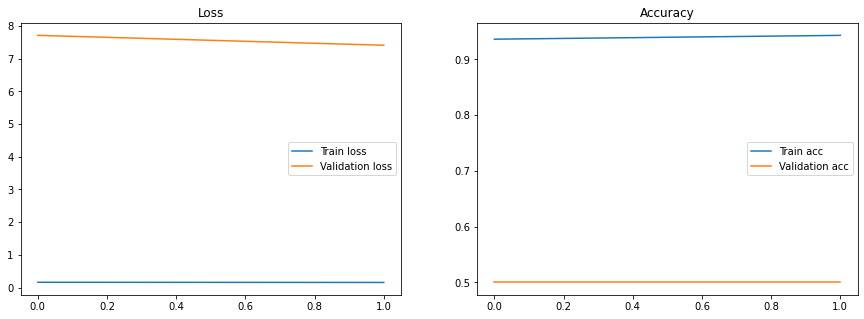

In [30]:
show_final_history(history)
model.load_weights(best_model_weights)
model_eval = model.evaluate_generator(test_data,steps=100)
print("Model Test Loss:",model_eval[0])
print("Model Test Accuracy:",model_eval[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")